## K-Means Clustering on a Multi-Class and Multi-Label Data Set

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df =  pd.read_csv("/Users/nikmag/Desktop/USC/INF_552_ML/HW4/Data_P2/Frogs_MFCCs.csv")

In [4]:
del df['RecordID']

In [5]:
df.columns = [i.lower().replace(" ","") for i in df.columns]
for i in ['family','genus','species']:
    df[i] = df[i].apply(lambda x: x.lower())

In [6]:
X = df.loc[:,[i for i in df.columns.tolist() if i not in ['family','genus','species']]]
y = df.loc[:,['family','genus','species']]

### Using Within Sum of Squares (WSS) to find the optimal K value for the clusters using Elbow method

In [38]:
wss = []
for k in range(2,11):    
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(X)
    wss.append(kmeans.inertia_)

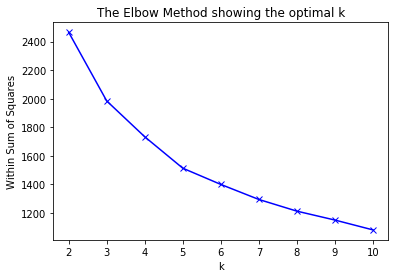

In [39]:
plt.plot(range(2,11), wss, 'bx-')
plt.xlabel('k')
plt.ylabel('Within Sum of Squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow is observed at a value of K = 5, after which the WSS decreases constantly. We do not want the value of K to be too large, as we'll get very small clusters

In each cluster, determine which family is the majority by reading the true labels. Repeat for genus and species.

### Running KMeans for K = 5

In [44]:
kmeans = KMeans(n_clusters=5, random_state=0)
cluster_labels = kmeans.fit_predict(X)

In [53]:
df = pd.concat([X,y,pd.DataFrame({'clus_labels':cluster_labels.tolist()})],axis = 1)

### Checking distribution of the clusters

In [55]:
df['clus_labels'].value_counts()

0    3558
3    1554
1    1032
4     619
2     432
Name: clus_labels, dtype: int64

In [70]:
for k in range(5):
    temp = df[df['clus_labels']==k]
    print('Cluster %s' % str(k+1))
    print('\n')
    print('Majority class in family - %s' % temp['family'].value_counts().index[0])
    print('Majority class in genus - %s' % temp['genus'].value_counts().index[0])
    print('Majority class in species - %s' % temp['species'].value_counts().index[0])

Cluster 1


Majority class in family - leptodactylidae
Majority class in genus - adenomera
Majority class in species - adenomerahylaedactylus


Cluster 2


Majority class in family - dendrobatidae
Majority class in genus - ameerega
Majority class in species - ameeregatrivittata


Cluster 3


Majority class in family - leptodactylidae
Majority class in genus - adenomera
Majority class in species - adenomeraandre


Cluster 4


Majority class in family - hylidae
Majority class in genus - hypsiboas
Majority class in species - hypsiboascordobae


Cluster 5


Majority class in family - hylidae
Majority class in genus - hypsiboas
Majority class in species - hypsiboascinerascens




Now for each cluster you have a majority label triplet (family, genus, species). Calculate the average Hamming distance between the true labels and the labels assigned by clusters.

In [74]:
d = {k:[] for k in range(5)}
for k in range(5):
    temp = df[df['clus_labels']==k]
    d[k].append(temp['family'].value_counts().index[0])
    d[k].append(temp['genus'].value_counts().index[0])
    d[k].append(temp['species'].value_counts().index[0])

In [84]:
d

{0: ['leptodactylidae', 'adenomera', 'adenomerahylaedactylus'],
 1: ['dendrobatidae', 'ameerega', 'ameeregatrivittata'],
 2: ['leptodactylidae', 'adenomera', 'adenomeraandre'],
 3: ['hylidae', 'hypsiboas', 'hypsiboascordobae'],
 4: ['hylidae', 'hypsiboas', 'hypsiboascinerascens']}

In [120]:
df['family_clus'] = 'none'
df['genus_clus'] = 'none'
df['species_clus'] = 'none'

In [121]:
for k in range(5):
    df['family_clus'] = np.where(df['clus_labels']==k,d[k][0],df['family_clus'])
    df['genus_clus'] = np.where(df['clus_labels']==k,d[k][1],df['genus_clus'])
    df['species_clus'] = np.where(df['clus_labels']==k,d[k][2],df['species_clus'])

In [139]:
predicted = df.loc[:,['family_clus','genus_clus','species_clus']].rename(columns={'family_clus':'family','genus_clus':'genus','species_clus':'species'})

In [140]:
actual = df.loc[:,['family','genus','species']]

In [141]:
match = {k:object for k in ['family','genus','species']}
for i in ['family','genus','species']:
    match[i] = np.where(actual[i] == predicted[i],1,0)

df_match = pd.DataFrame(match)

df_match['sum'] = df_match[['family','genus','species']].sum(axis=1)
df_match['hamming_match'] = df_match['sum'].astype(float)/3.0

In [151]:
print('hamming score = %s' % str(df_match['hamming_match'].sum(axis=0)/len(df_match)))

hamming score = 0.8322446143154969


The hamming score observed after clustering is 0.83, which is not that bad. This proves that K-means is a decent classifier for this 